In [1]:
from components.gptmodel import GPTModel

In [2]:
import lightning as L

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 256,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": True
}

In [4]:
import torch.nn as nn
import torch

In [5]:
class LitGPTModel(L.LightningModule):
    def __init__(self, GPTModel):
        super().__init__()
        self.model = GPTModel
        self.train_losses = []
        self.learning_rates = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self.model(x)
        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=1e-3, weight_decay=0.1
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

In [6]:
from components.data import create_dataloader_v2

In [7]:
dataset_scale = 100

In [8]:
%%time

train_file = "../data/TinyStories/TinyStoriesV2-GPT4-train.txt"
with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read()

train_len = len(train_text)
train_text = train_text[:train_len // dataset_scale]
train_loader = create_dataloader_v2(
    train_text,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=11
)

CPU times: user 17.4 s, sys: 4.51 s, total: 21.9 s
Wall time: 21.9 s


In [9]:
val_file = "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt"
with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read()

val_len = len(val_text)
val_text = val_text[:val_len // dataset_scale]
val_loader = create_dataloader_v2(
    val_text,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=11
)

In [10]:
model = GPTModel(GPT_CONFIG_124M)
litmodel = LitGPTModel(model)

In [11]:
%%time

trainer = L.Trainer(max_epochs=1, enable_progress_bar=True)
trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gebrial/miniforge3/envs/fromscratch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | GPTModel | 10.9 M | train
---------------------------------

Sanity Checking: |                                                                             | 0/? [00:00<?,…

Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 2min 15s, sys: 3.11 s, total: 2min 18s
Wall time: 2min 19s


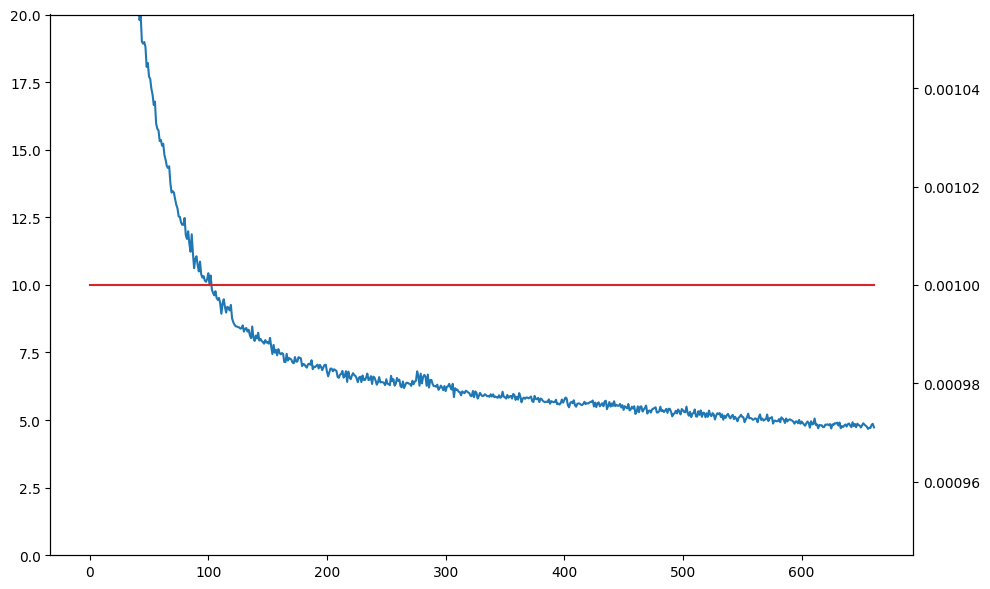

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses)
ax1.set_ylim(0, 20)

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, color="tab:red")

plt.tight_layout()
plt.show()